# Informer Demo

Colab Examples: We provide google colabs to help reproduce and customize our repo, 
which includes `experiments(train and test)`, `prediction`, `visualization` and `custom data`

In [2]:
import sys, os
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns 
from pathlib import Path 
from utils.tools import dotdict
from utils.read_aviation import read_aviation
from exp.exp_informer import Exp_Informer
import torch
from data.data_loader import Dataset_Pred, Dataset_AviationPred, Dataset_Aviation
from torch.utils.data import DataLoader
import hyperopt 
import informer_aviation_hpo



sns.set_theme(context="paper", style="whitegrid")


# shap default cmap at our disposal 
colors = ["#ff0051", "#FFFFFF", "#008bfb"] # first color is magneta , (optional middle =whilte), last is blue
shap_cmap = mcolors.LinearSegmentedColormap.from_list("Shap", colors, N=60)
shap_cmap_inv = mcolors.LinearSegmentedColormap.from_list("invShap", colors[::-1], N=60)
colors = ["#ff0051", "#008bfb"] 
shap2_cmap = mcolors.LinearSegmentedColormap.from_list("Shap2", colors, N=60)
shap2_cmap_inv = mcolors.LinearSegmentedColormap.from_list("invShap2", colors[::-1], N=60)


# LHT default cmpa at our disposal 
lht_blue = "#45546b" # #05164D
lht_blue2 = "#05164D"
lht_yellow = "#FFAD00"
colors = ["#FFFFFF", lht_blue]
lhtBu_cmap = mcolors.LinearSegmentedColormap.from_list("lhtBu", colors, N=60)
colors = ["#FFFFFF", lht_blue2]
lhtBu2_cmap = mcolors.LinearSegmentedColormap.from_list("lhtBu", colors, N=60)
colors = ["#FFAD00", "#FFFFFF", lht_blue]
lhtYeWhBu_cmap = mcolors.LinearSegmentedColormap.from_list("lhtYeWhBu", colors, N=60)
colors = ["#FFAD00", lht_blue]
lhtYeBu_cmap = mcolors.LinearSegmentedColormap.from_list("lhtYeBu", colors, N=60)

# lht greys: #cccccc, #F4F4F4, #999999, #666666

colors = ["#e6194b",
"#3cb44b",
"#ffe119",
"#0082c8",
"#f58231",
"#911eb4",
"#46f0f0",
"#f032e6",
"#d2f53c",
"#fabebe",
"#008080",
"#e6beff",
"#aa6e28",
"#fffac8",
"#800000",
"#aaffc3",
"#808000",
"#ffd8b1",
"#000080",
"#808080",
"#ffffff",
"#000000"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=20)


def f_wrap_space_eval(hp_space: dict, trial: hyperopt.Trials):
    """
    Utility function for more consise optimization history extraction
    
    Parameters:
    ----------------
    hp_space : hyperspace from which points are sampled
    trial : hyperopt.Trials object
    
    Returns:
    ----------------
    : dict(
        k: v
    ), where k - label of hyperparameter, v - value of hyperparameter in trial
    """
    return hyperopt.space_eval(hp_space, {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})

def f_unpack_dict(dct: dict):
    """
    Unpacks all sub-dictionaries in given dictionary recursively. There should be no duplicated keys 
    across all nested subdictionaries, or some instances will be lost without warning
    
    Parameters:
    ----------------
    dct : dictionary to unpack
    
    Returns:
    ----------------
    : unpacked dictionary
    """
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v
            
    return res

/usr/local/Caskroom/miniconda/base/envs/informer37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'Aviation' # data
args.root_path = './data/_data/aviation/01' # root path of data file
args.data_path = 'train_lower.parquet.gzip' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'SUM_ophrs_act' # target feature in S or MS task
args.freq = 'm' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './checkpoints' # location of model checkpoints

args.seq_len = 24 # input sequence length of Informer encoder
args.label_len = 12 # start token length of Informer decoder
args.pred_len = 6 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor   # --factor 
args.d_model = 64 # 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 128 # 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 8
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 200
args.patience = 70
args.des = 'Exp'


args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0,1,2,3'

# Aviation specific setting 
args.mode = 'single-emb'
args.do_predict = True


args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [21]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'Aviation': {'data': 'train_lower.parquet.gzip', 'T':'SUM_ophrs_act', 'M': [], 'mode': 'single-emb'} # mode: ['single-emb', 'multi-emb']
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data'] # overrides data_path via data setting in data_parser.
    args.target = data_info['T']       # overrides target
    if data_info[args.features] == [] and args.data == "Aviation": 
        args.mode = data_info['mode']
        tmp, _ = read_aviation(args.root_path, args.data_path, args.mode)
        ncols = tmp.columns.size
        data_info['M'] = [ncols, ncols, ncols]
        args.des = args.des + "-" + args.mode 
    args.enc_in, args.dec_in, args.c_out = data_info[args.features] # get either keys: [M, S, MS] depending on --features option

args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'Aviation', 'root_path': './data/_data/aviation/01', 'data_path': 'train_lower.parquet.gzip', 'features': 'M', 'target': 'SUM_ophrs_act', 'freq': 'm', 'checkpoints': './checkpoints', 'seq_len': 24, 'label_len': 12, 'pred_len': 6, 'enc_in': 152, 'dec_in': 152, 'c_out': 152, 'factor': 5, 'd_model': 64, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 128, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 8, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 200, 'patience': 70, 'des': 'Exp-single-emb', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'mode': 'single-emb', 'do_predict': True, 'detail_freq': 'm'}


In [22]:
# read best case and overwrite args 
with open('./informer_aviation_hpotrials.pkl', 'rb') as fr:  
    trials = pickle.load(fr)    
hyperspace = informer_aviation_hpo.get_informer_hyperspace()
# samples = [f_unpack_dict(f_wrap_space_eval(hyperspace, x)) for x in trials.trials]
# trialsdf = pd.json_normalize(trials)
# trialsdf = pd.concat([trialsdf, pd.json_normalize(samples)], axis=1)
# trialsdf.T.head(28)
best = f_unpack_dict(f_wrap_space_eval(hyperspace, trials.best_trial))

# overwrite args attributes 
for k, v in best.items(): 
    setattr(args, k, v)
print('Best args in experiment:')
print(args)


Best args in experiment:
{'model': 'informer', 'data': 'Aviation', 'root_path': './data/_data/aviation/01', 'data_path': 'train_lower.parquet.gzip', 'features': 'M', 'target': 'SUM_ophrs_act', 'freq': 'm', 'checkpoints': './checkpoints', 'seq_len': 36, 'label_len': 24, 'pred_len': 6, 'enc_in': 152, 'dec_in': 152, 'c_out': 152, 'factor': 5, 'd_model': 64, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 16, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 2, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 200, 'patience': 70, 'des': 'Exp-single-emb', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'mode': 'single-emb', 'do_predict': True, 'detail_freq': 'm'}


In [23]:
Exp = Exp_Informer
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(
                args.model, args.data, Path(args.root_path).name, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, 
                args.embed, args.distil, args.mix, args.des, ii)

    exp = Exp(args) # set experiments: independent of ii at the initialization stage
    best_model_path = Path(args.checkpoints) / setting / "checkpoint.pth"
    if best_model_path.is_file(): 
        print('>>>>>>>Loading model: {}>>>>>>>>>>>>>>>>'.format(setting))
        exp.model.load_state_dict(torch.load(best_model_path))
    else: 
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)
    
    # Aviation does not have testing case but directly out-of-sample forecast in each rolling backtesting iteration.
    if args.data != "Aviation": 
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

    # if args.do_predict:
    #     print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    #     exp.predict(setting, load=True)

    torch.cuda.empty_cache()


Use CPU
>>>>>>>Loading model: informer_Aviation_01_ftM_sl36_ll24_pl6_dm64_nh8_el2_dl1_df16_atprob_fc5_ebtimeF_dtTrue_mxTrue_Exp-single-emb_0>>>>>>>>>>>>>>>>


# Insample Prediction

In [24]:
# loop over train/val 
insample_preds = [] 
insample_data = []
# insample_trues = [] 
for flag in ['train', 'val']: 
    # read pred
    path = './results/' + setting + f'/{flag}_prediction.npy'
    pred = np.load(path)
    insample_preds.append(pred)
    
    # path = './results/' + setting + f'/true{flag}_prediction.npy'
    # true = np.load(path)
    # insample_trues.append(true)

    # read meta 
    path = './results/' + setting + f'/{flag}_meta.pkl'
    with open(path, 'rb') as fr: 
        meta = pickle.load(fr)
    
    Data = Dataset_Aviation
    data_set = Data(
        root_path=meta['root_path'],
        data_path=meta['data_path'],
        flag=flag,
        size=meta['size'],
        features=meta['features'],
        target=meta['target'],
        timeenc=meta['timeenc'],
        freq=meta['freq']
    )
    # data_loader = DataLoader(
    #     insample_data[0],
    #     batch_size=args.batch_size,
    #     shuffle=False,
    #     num_workers=args.num_workers,
    #     drop_last=False
    # )
    insample_data.append(data_set)


In [25]:
# this code block helps to check if train/val_true is the same as the df_raw groundtruth 
# h = 1 
# case = {'oper': 'plm', 'actype': 'a330'}
# figsize=(7, 3)

# obj = insample_data[0]
# df_raw, hiercols = read_aviation(obj.root_path, obj.data_path, mode=obj.mode)
# num_total = len(df_raw)
# num_train = int(num_total*0.9)                # the insample_data[0].data_x.shape
# num_val = num_total - num_train + obj.seq_len # the insample_data[1].data_x.shape
# df_raw.columns = hiercols 
# df_raw.index.freq = "MS"
# df_raw = df_raw.T 


# query = "&".join([f"{k}=='{v}'" for k, v in case.items()])
# queryidx = df_raw.reset_index().query(query).index
# gt = df_raw.query(query).melt().set_index('date').squeeze()
# train_pred, val_pred = insample_preds[0][:, h-1, queryidx].squeeze(), insample_preds[1][:, h-1, queryidx].squeeze()
# train_date, val_date = df_raw.columns[obj.seq_len-1:num_train-obj.pred_len].shift(h), df_raw.columns[num_train-1:num_total-obj.pred_len].shift(h)
# assert len(train_pred) == len(train_date), f"train pred shape {len(train_pred)} != date len {len(train_date)}"
# assert len(val_pred) == len(val_date), f"val pred shape {len(val_pred)} != date len {len(val_date)}"
# train_true, val_true = insample_trues[0][:, h-1, queryidx].squeeze(), insample_trues[1][:, h-1, queryidx].squeeze()


# fig = plt.figure(figsize=figsize)
# _ = plt.plot(gt.index, gt.values, marker='.', label='actual')
# plt.plot(train_date, train_pred, marker='.', label='train-pred')
# plt.plot(val_date, val_pred, marker='.', label='val-pred')
# plt.plot(train_date, train_true, label='train-true')
# plt.plot(val_date, val_true, label='val-true')
# ylim = plt.gca().get_ylim()
# plt.vlines(x=df_raw.columns[num_train-1], ymin=ylim[0], ymax=ylim[1], linestyles="--", alpha=.5, colors=lht_blue)
# plt.legend()

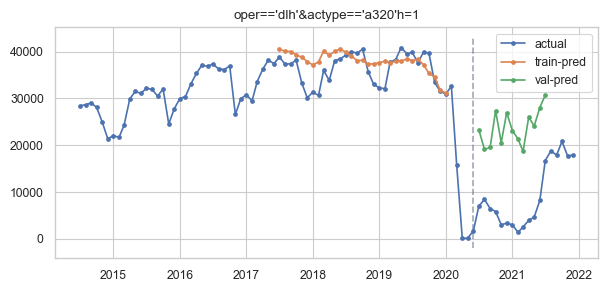

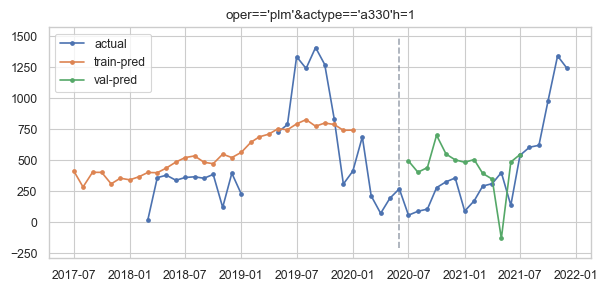

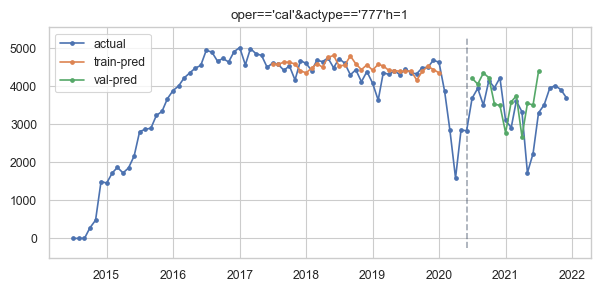

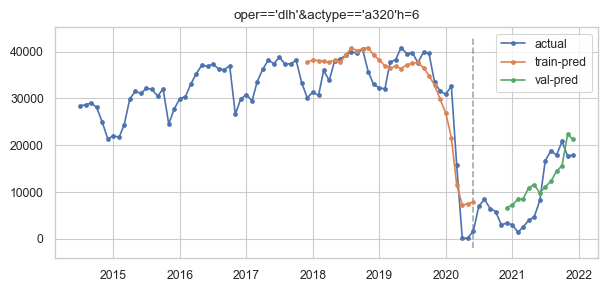

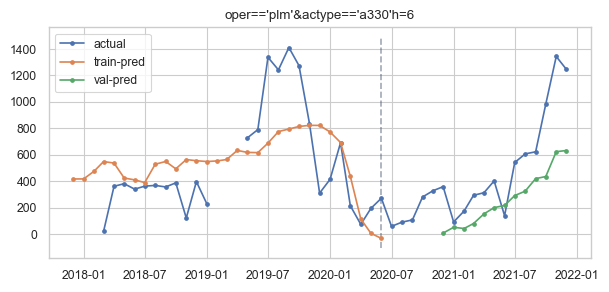

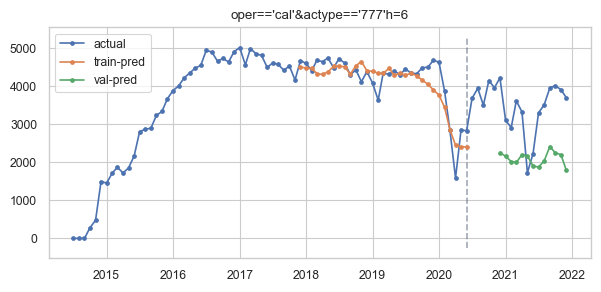

In [31]:
# plot prediction vs gt 
def insample_plot(case: dict, h: int, insample_data=insample_data, figsize=(7,3)): 
    # insample_preds[0].shape, insample_preds[1].shape # ((52, 6, 152), (4, 6, 152)) 
    obj = insample_data[0]
    df_raw, hiercols = read_aviation(obj.root_path, obj.data_path, mode=obj.mode)
    num_total = len(df_raw)
    num_train = int(num_total*0.8)                # the insample_data[0].data_x.shape
    num_val = num_total - num_train + obj.seq_len # the insample_data[1].data_x.shape
    df_raw.columns = hiercols 
    df_raw.index.freq = "MS"
    df_raw = df_raw.T 
    query = "&".join([f"{k}=='{v}'" for k, v in case.items()])
    queryidx = df_raw.reset_index().query(query).index
    gt = df_raw.query(query).melt().set_index('date').squeeze()
    train_pred, val_pred = insample_preds[0][:, h-1, queryidx].squeeze(), insample_preds[1][:, h-1, queryidx].squeeze()
    train_date, val_date = df_raw.columns[obj.seq_len-1:num_train-obj.pred_len].shift(h), df_raw.columns[num_train-1:num_total-obj.pred_len].shift(h)
    assert len(train_pred) == len(train_date), f"train pred shape {len(train_pred)} != date len {len(train_date)}"
    assert len(val_pred) == len(val_date), f"val pred shape {len(val_pred)} != date len {len(val_date)}"

    fig = plt.figure(figsize=figsize)
    _ = plt.plot(gt.index, gt.values, marker='.', label='actual')
    plt.plot(train_date, train_pred, marker='.', label='train-pred')
    plt.plot(val_date, val_pred, marker='.', label='val-pred')
    ylim = plt.gca().get_ylim()
    plt.vlines(x=df_raw.columns[num_train-1], ymin=ylim[0], ymax=ylim[1], linestyles="--", alpha=.5, colors=lht_blue)
    plt.legend()
    plt.title(query+'h='+str(h))


hh = [1,6] # specific horizon 1-6
cases = [
    {'oper': 'dlh', 'actype': 'a320'}, 
    {'oper': 'plm', 'actype': 'a330'}, 
    {'oper': 'cal', 'actype': '777'}, 
]
for h in hh: 
    for case in cases: 
        insample_plot(case, h)





## Out-of-sample Prediction

In [32]:
# read prediction from setting 
path = './results/'+setting+'/real_prediction.npy'
print("Load prediction from path {}".format(path))
prediction = np.load(path) # shape (1, 6, 152)

Data = Dataset_AviationPred
timeenc = 0 if args.embed!='timeF' else 1

freq = args.detail_freq
obj = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='pred',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
# data_loader = DataLoader(
#     data_set,
#     batch_size=1,
#     shuffle=False,
#     num_workers=args.num_workers,
#     drop_last=False)



Load prediction from path ./results/informer_Aviation_01_ftM_sl36_ll24_pl6_dm64_nh8_el2_dl1_df16_atprob_fc5_ebtimeF_dtTrue_mxTrue_Exp-single-emb_0/real_prediction.npy


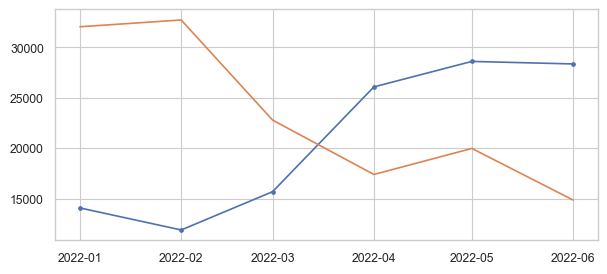

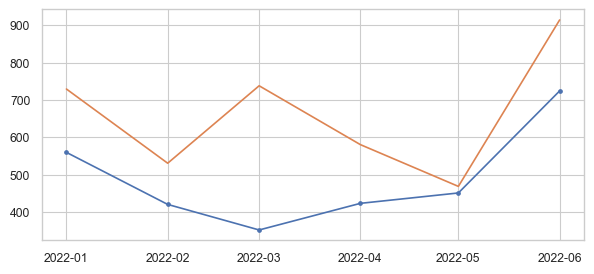

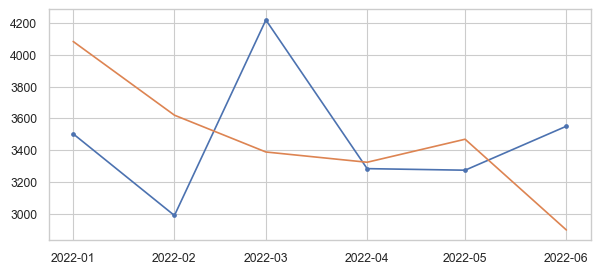

In [33]:
# read ground truth 
path = Path(args.root_path) / "test_lower.parquet.gzip"
dfcommon = pd.read_parquet("/Users/mbpr/Bitbucket/fh_forecast_model/cache/preprocessed/df_common.parquet.gzip").fillna(np.nan)

def outsample_plot(case: dict, figsize=(7, 3), dfcommon=dfcommon, insample_data=insample_data): 
    obj = insample_data[0]
    df_raw, hiercols = read_aviation(obj.root_path, obj.data_path, mode=obj.mode)
    df_raw.columns = hiercols 
    df_raw.index.freq = "MS"
    df_raw = df_raw.T 
    
    query = "&".join([f"{k}=='{v}'" for k, v in case.items()])
    queryidx = df_raw.reset_index().query(query).index
    test_pred = prediction[:, :, queryidx].squeeze() # 1-6 months ahead preds
    test_date = pd.date_range(df_raw.columns.values[-1], periods=obj.pred_len+1, freq='MS')[1:]
    assert len(test_pred) == len(test_date), f"test pred shape {len(test_pred)} != date len {len(test_date)}"
    gt = dfcommon.query(query).set_index('date')["SUM_ophrs_act"].squeeze()
    mask = gt.index.isin(test_date)
    gt = gt[mask]

    fig = plt.figure(figsize=figsize)
    _ = plt.plot(gt.index, gt.values, marker='.', label='actual')
    plt.plot(test_date, test_pred, label='test-pred')
    plt.show()

for case in cases: 
    outsample_plot(case)

### More details about Prediction - prediction function

In [ ]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds

# you can also use this prediction function to get result
# prediction = predict(exp, setting, True)

## Visualization

In [37]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

# preds = np.load('./results/'+setting+'/pred.npy')
# trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
# preds.shape, trues.shape

In [55]:
Data = Dataset_Aviation
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [56]:
args.output_attention = True
exp = Exp(args)
model = exp.model
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use CPU


<All keys matched successfully>

In [57]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [66]:
len(attn), attn[0].shape, attn[1].shape #, attn[2].shape

(2, torch.Size([1, 8, 96, 96]), torch.Size([1, 8, 48, 48]))

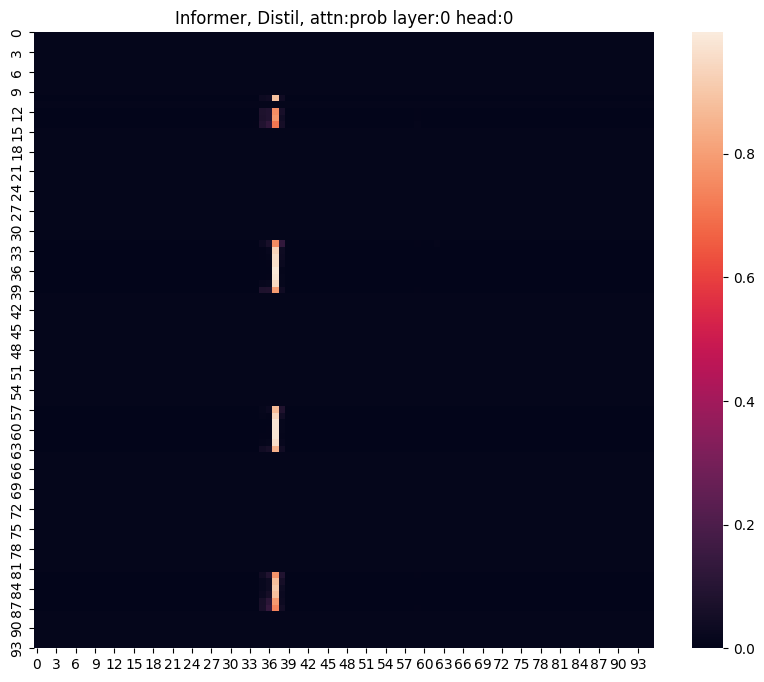

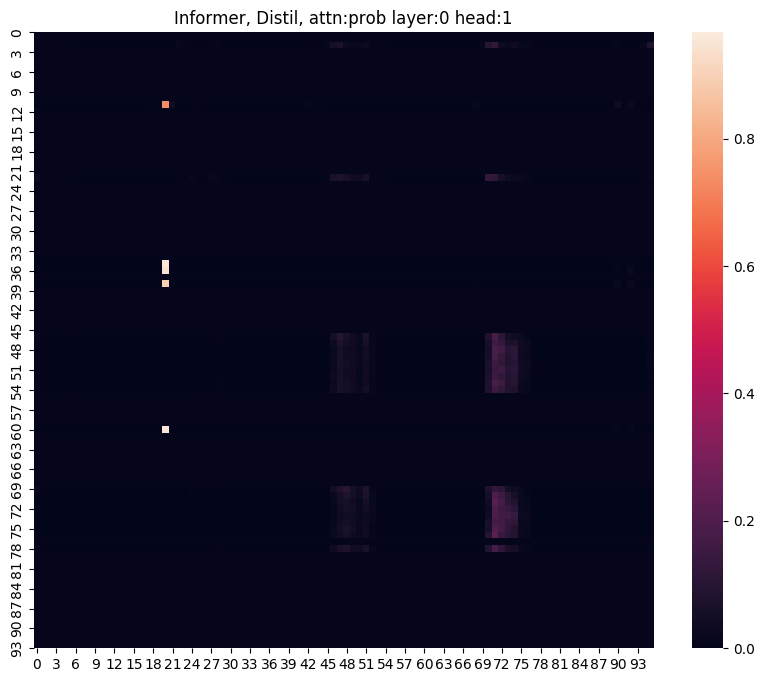

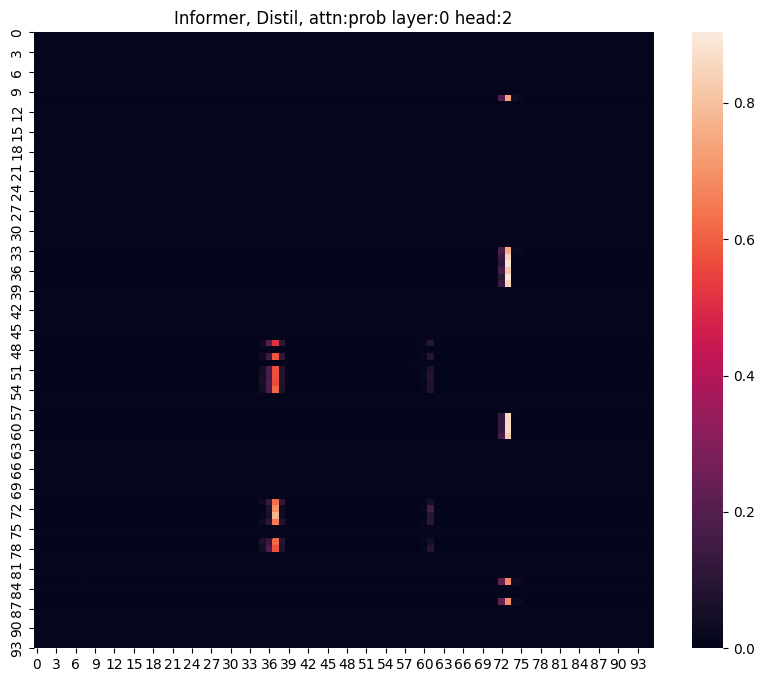

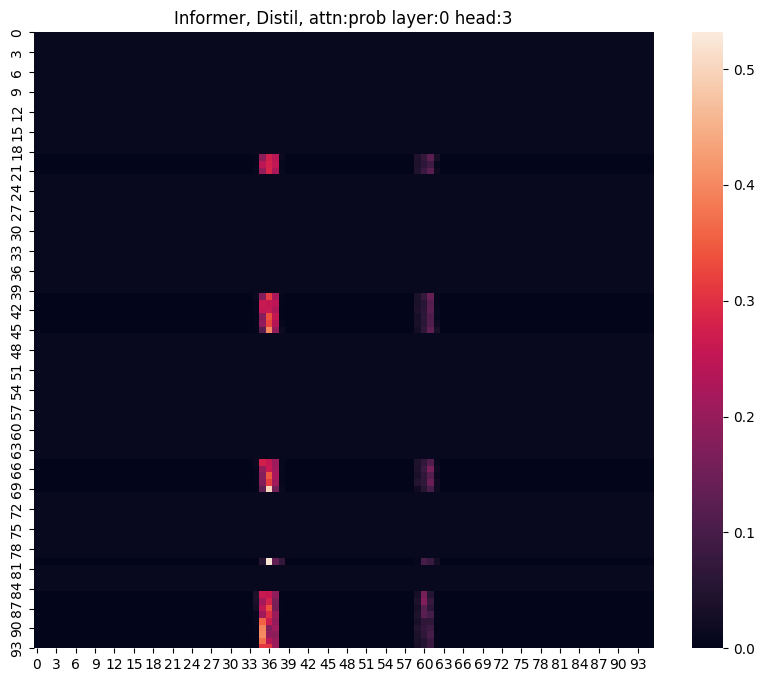

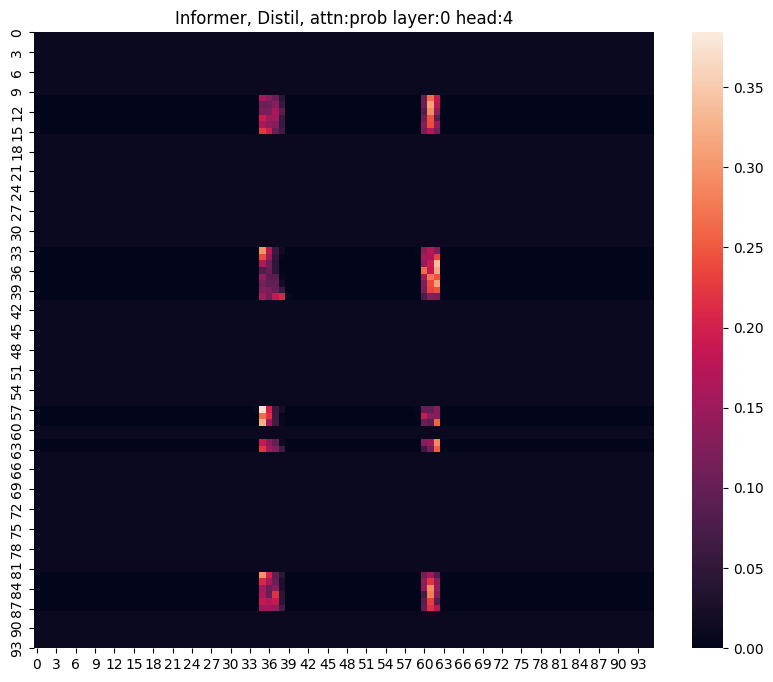

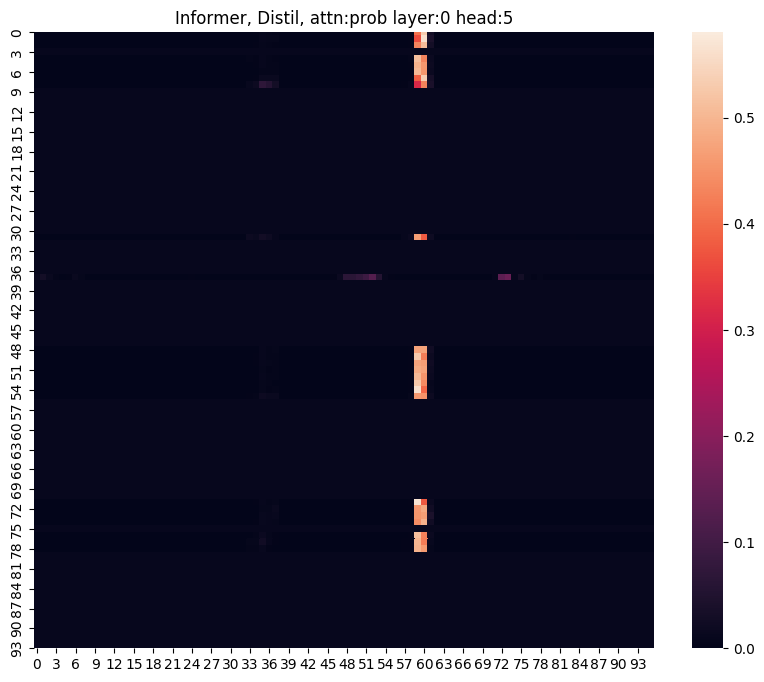

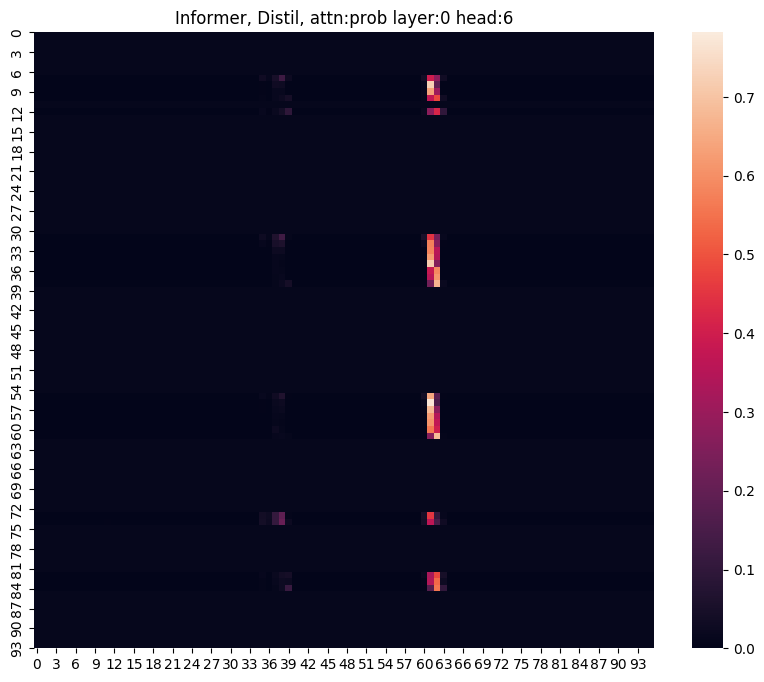

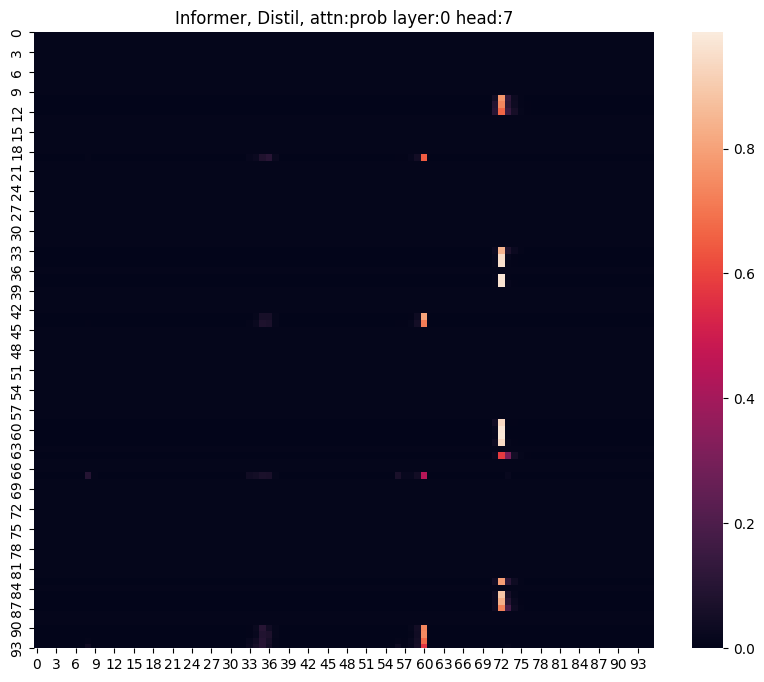

In [61]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

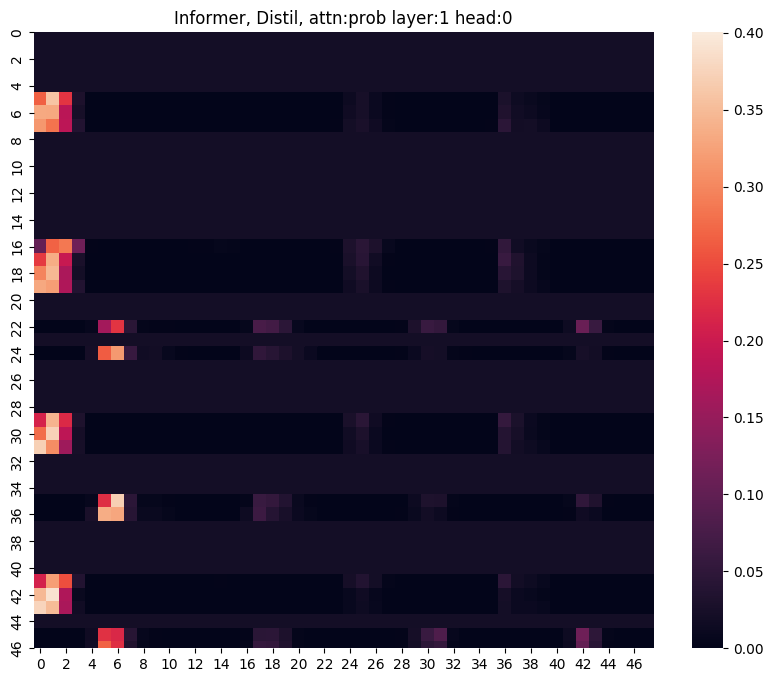

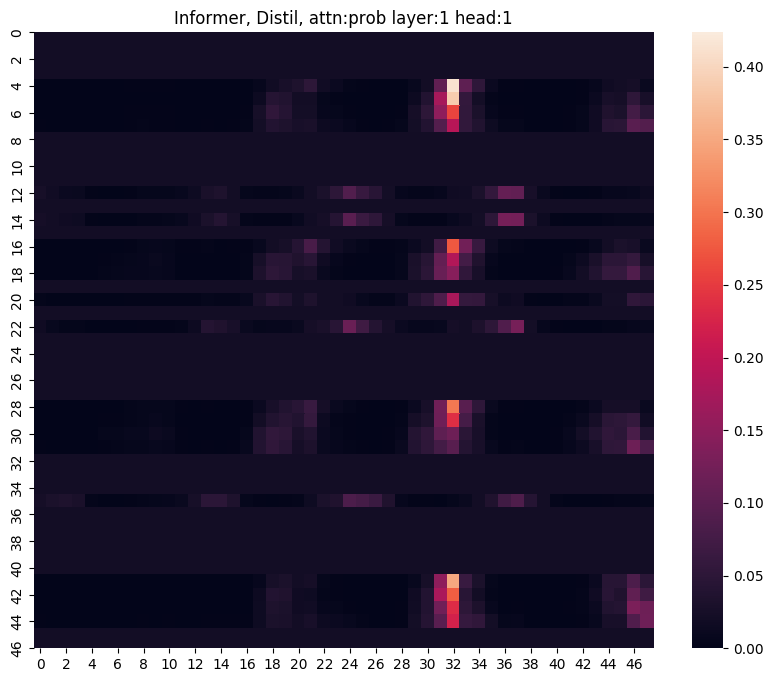

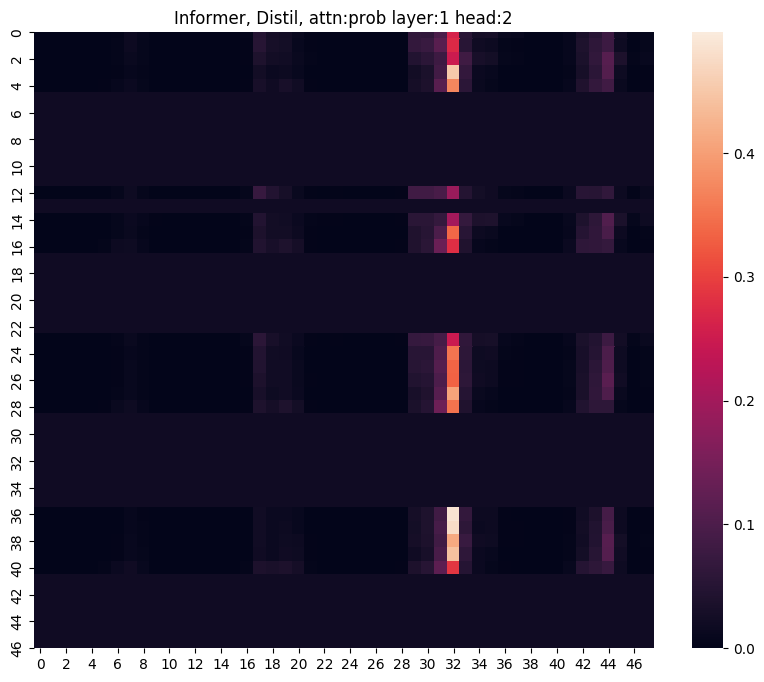

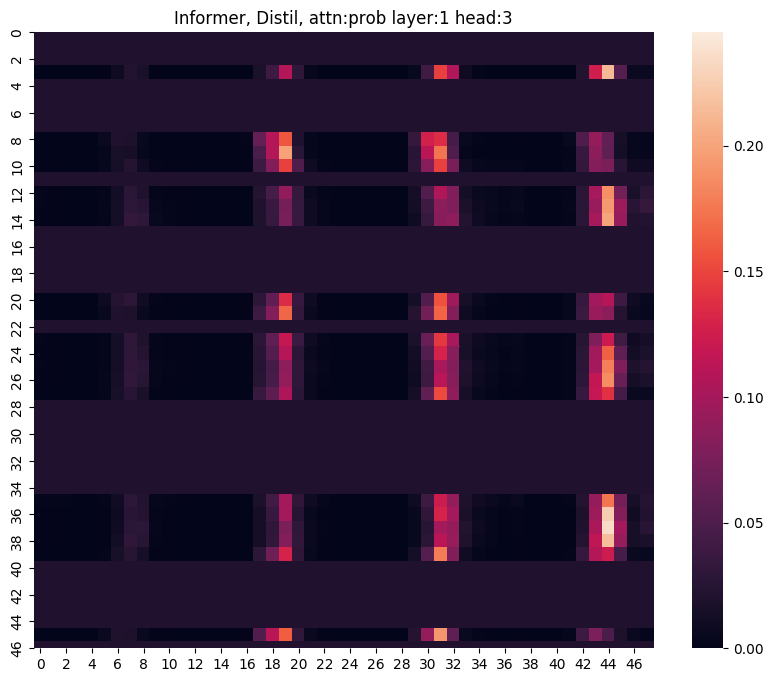

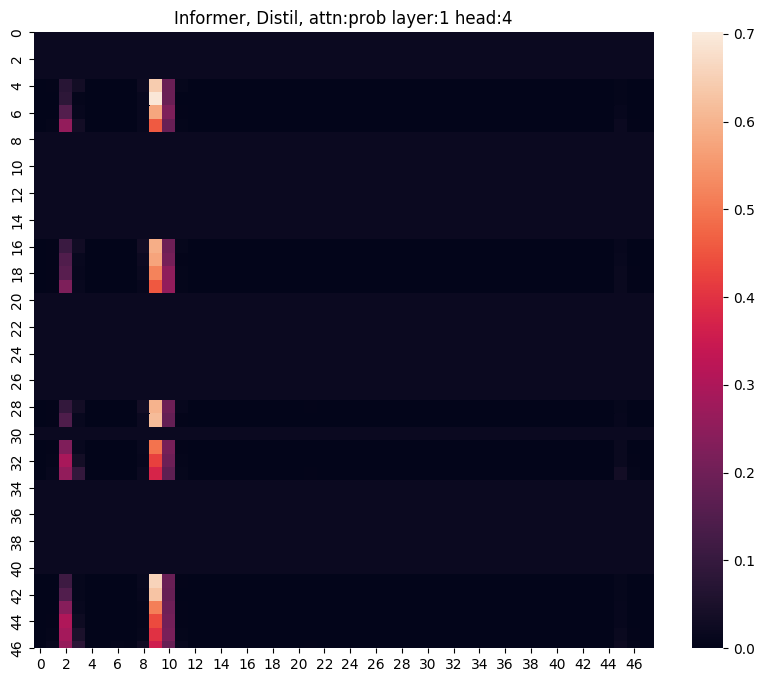

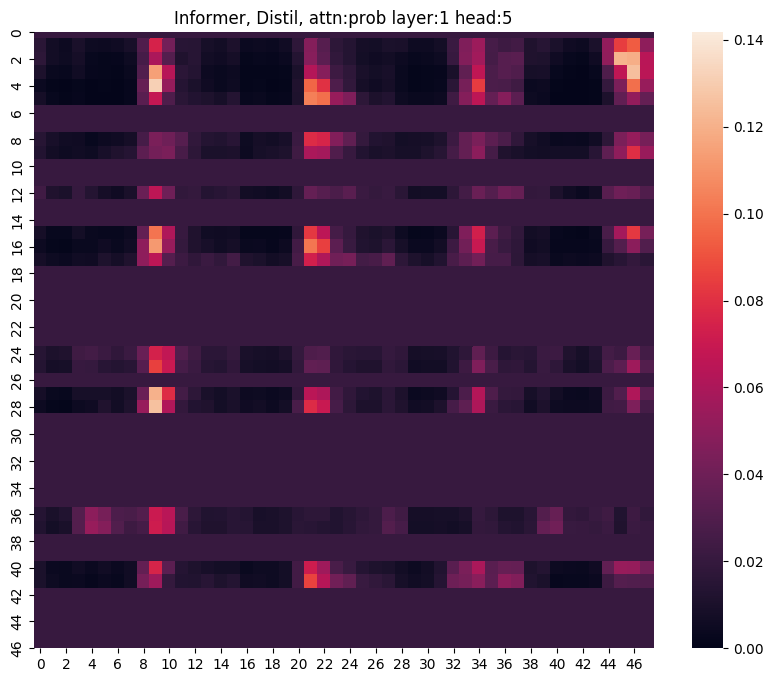

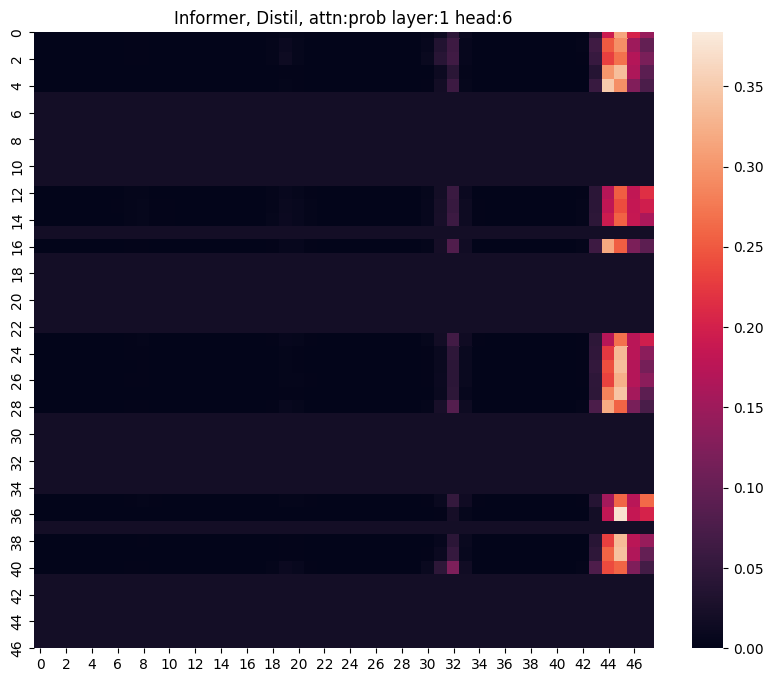

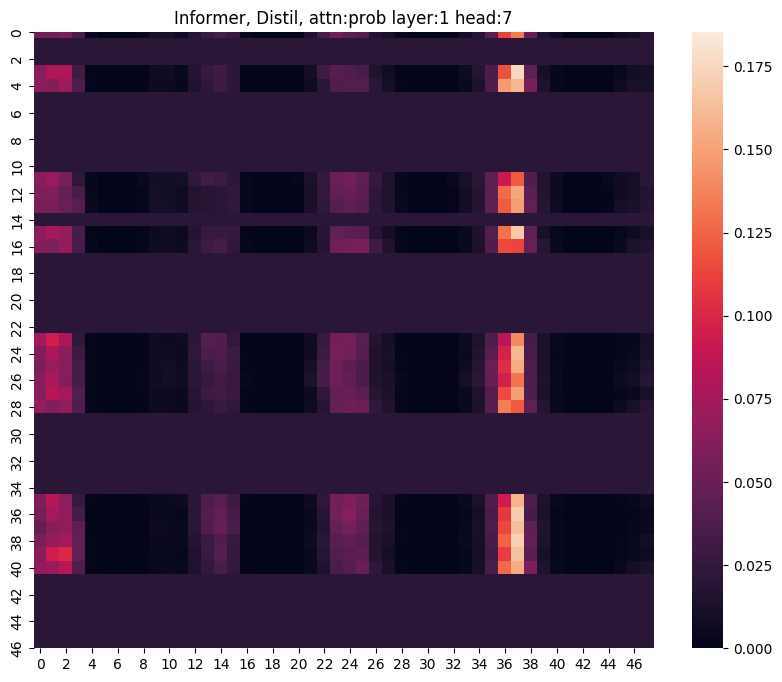

In [62]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()